In [1]:
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
from datetime import datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time

# 500 Best Video Games of all times according to metacritic 

## 1. Scraping relevant data

#### To avoid my IP being blocked

In [2]:
headers = {
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
    }

#### Base URL to get the TOP results

In [3]:
url = 'https://www.metacritic.com/browse/games/score/metascore/all?page=0'
response = get(url, headers=headers)

In [4]:
html_soup = BeautifulSoup(response.text)

In [5]:
games_containers = html_soup.find_all('td', class_='clamp-summary-wrap')

#### Loop through 5 first pages to get the 500 best games 

In [6]:
for i in range(1, 5) : 
    url_tmp = 'https://www.metacritic.com/browse/games/score/metascore/all?page='+str(i)
    response_tmp = get(url_tmp, headers=headers)
    html_soup_tmp = BeautifulSoup(response_tmp.text)
    containers_tmp = html_soup_tmp.find_all('td', class_='clamp-summary-wrap')
    games_containers = games_containers + containers_tmp

#### Lists to put all elements in 

In [7]:
names = []  
release = [] 
platform = [] 
user_rating = [] 
metacritic_rating = [] 
genres = []
developers = []


#### Function string to date to parse the release date 

In [8]:
def str_to_date(date) : 
    return datetime.strptime(date, "%B %d, %Y")

#### loop to get all metacritic info in to the lists

In [9]:
for game in games_containers : 
    if game.find('a', class_='title') is not None: 
        names.append(game.h3.text)
    else : 
        names.append('not_found')
    if game.find('span', class_='data') is not None : 
        platform.append(game.find('span', class_='data').text.strip('\n'))
    else : 
        platform.append('not_found')
    if game.find('div', class_='metascore_w user large game positive') is not None : 
        user_rating.append(float(game.find('div', class_='metascore_w user large game positive').text))
    else : 
        user_rating.append(-1.0)
    if game.select('div.clamp-details span')[2] is not None : 
        release.append(str_to_date(game.select('div.clamp-details span')[2].text))
    else : 
        release.append(None)
    if game.find('div', class_='metascore_w large game positive') is not None : 
        metacritic_rating.append(float(game.find('div', class_='metascore_w large game positive').text)) 
    else : 
        metacritic_rating.append(-1.)

#### Function to parse results (remove the title and annotations) 

In [10]:
def clean_columns(value, to_remove) :
    return value.replace(to_remove, '').replace('[a]', '')

#### To get additional info (developers and genre) we get wikipedia pages of each game

In [11]:
base_url = 'https://en.wikipedia.org/wiki/'

In [12]:
developers = []
genres = []

#### Loop through the names and query wikipedia, this task is pretty long as wikipedia limits traffic, av. 250 seconds 

In [13]:
start_time = time.time()
for name in names : 
    if name is not None : 
        name_parsed = name.replace(' ', '_')
        url_to_request = base_url + name_parsed 
        response_content = get(url_to_request, headers = headers)
        html_soup =  BeautifulSoup(response_content.text)
        genre = 'not_found'
        developer = 'not_found'
        game_sum_card = html_soup.find('table', class_='infobox hproduct')
        if game_sum_card is not None : 
            tab_el = game_sum_card.find_all('tr') 
            for el in tab_el : 
                if 'Genre(s)' in el.text :
                    genre = clean_columns(el.text, 'Genre(s)')
                if 'Developer(s)' in el.text : 
                    developer = clean_columns(el.text, 'Developer(s)')
        genres.append(genre)
        developers.append(developer)
run_time = time.time() - start_time
print(run_time)

231.53614377975464


#### Keep only first registered genre 

In [14]:
genres_primary = []
for genre in genres : 
    if ',' in genre : 
        tmp = genre.split(',')[0]
        genres_primary.append(tmp)
    else :
        genres_primary.append(genre)


#### Put the data in pandas dataframe for analysis

In [15]:
data_raw = [names]
data_raw.append(release)
data_raw.append(platform)
data_raw.append(user_rating)
data_raw.append(metacritic_rating)
data_raw.append(genres_primary)
data_raw.append(developers)
col_names = ["name", "release_date", "platform", "user_rating", "metacritic_rating", "genres", "developers"]
df = pd.DataFrame(np.array(data_raw).T, columns=col_names)

#### Save dataframe to csv 

In [44]:
df.to_csv('df_original.csv')

## 2. Analysis 

In [16]:
num_col = ["metacritic_rating", "user_rating"]

In [17]:
nom_col = ["name", "release_date", "platform", "genres", "developers"]

#### Check null values for numerical variables 

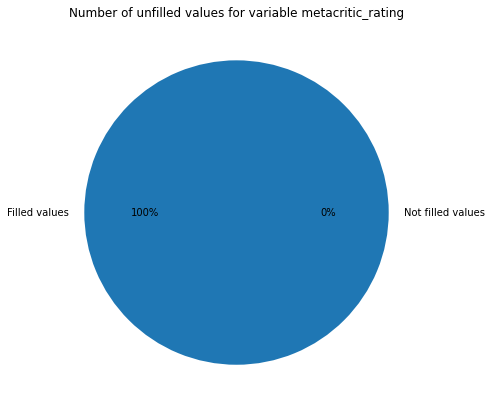

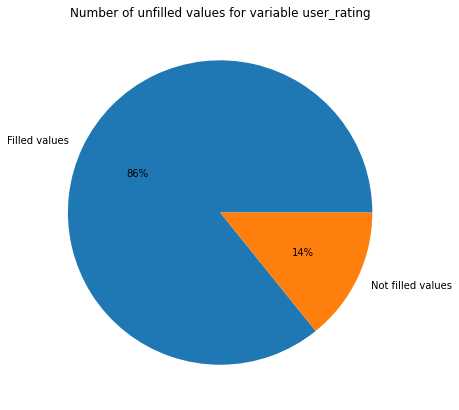

In [18]:
for i in num_col : 
    values = [df[df[i] != -1.0].shape[0], df[df[i] == -1.0].shape[0]] 
    labels = ['Filled values', 'Not filled values'] 
    fig = plt.figure(figsize =(10, 7)) 
    plt.pie(values, labels = labels, autopct='%1.0f%%') 
    plt.title('Number of unfilled values for variable '+i)
    plt.show() 

#### Check null values for nominal variables 

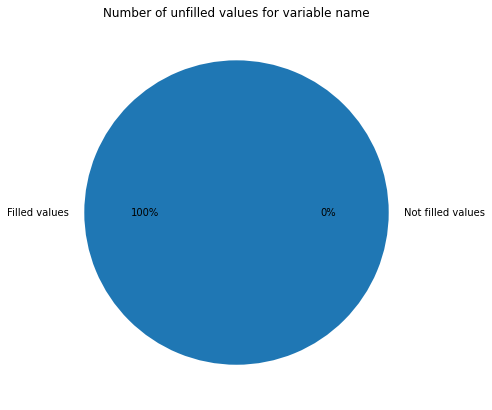

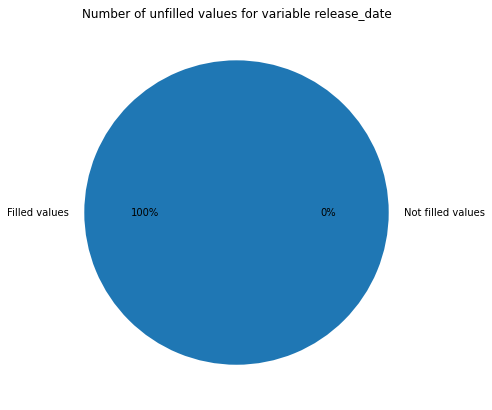

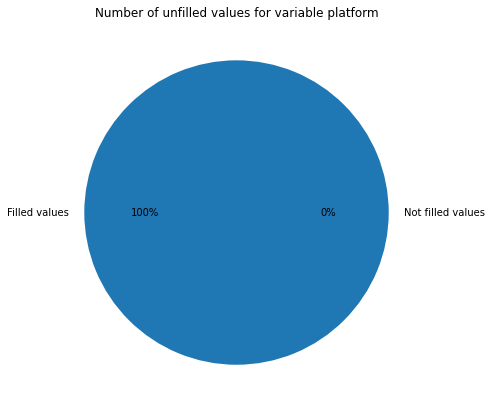

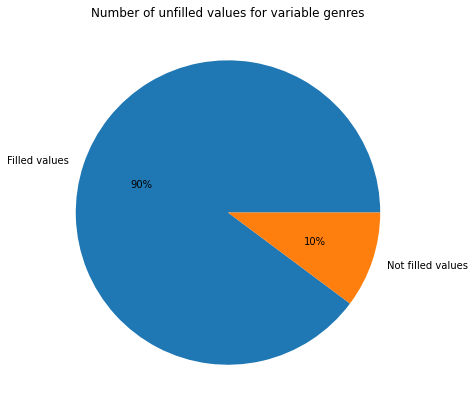

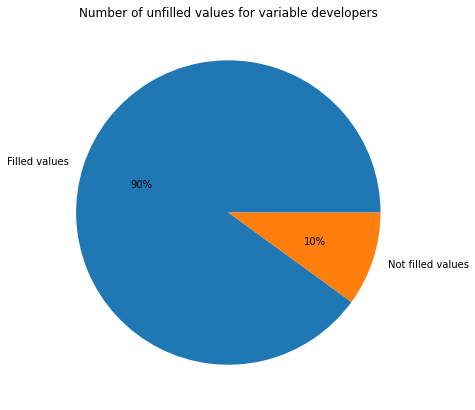

In [19]:
for i in nom_col : 
    values = [df[df[i] != 'not_found'].shape[0], df[df[i] == 'not_found'].shape[0]] 
    labels = ['Filled values', 'Not filled values'] 
    fig = plt.figure(figsize =(10, 7)) 
    plt.pie(values, labels = labels, autopct='%1.0f%%') 
    plt.title('Number of unfilled values for variable '+i)
    plt.show() 

##### __Conclusion__ : user_rating, developers and genres have null values

#### Create dataset without unfilled valued

In [20]:
df_without_null = df[df.user_rating != -1]
df_without_null = df_without_null[df_without_null.developers != 'not_found']
df_without_null = df_without_null[df_without_null.genres != 'not_found']

#### Save cleaned df to csv 

In [46]:
df_without_null.to_csv('df_clean.csv')

#### How many games per platform are in the top 500

<AxesSubplot:>

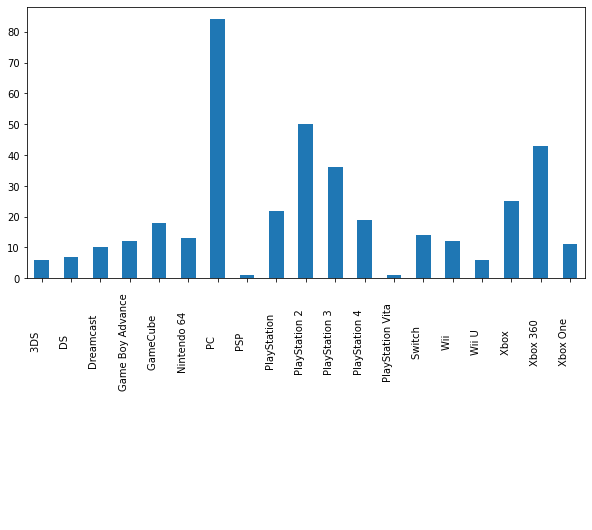

In [21]:
y = df_without_null['platform']
y.value_counts().sort_index().plot.bar(figsize=(10,5), x='Target Value', y='Number of Occurrences')

##### __Conclusion__ : Most of the top games were edited for PS2, XBOX360 and PC, while very little games from the top 500 were made for PSP and PS vita 

#### How many games per genre are in the top 500 

<AxesSubplot:>

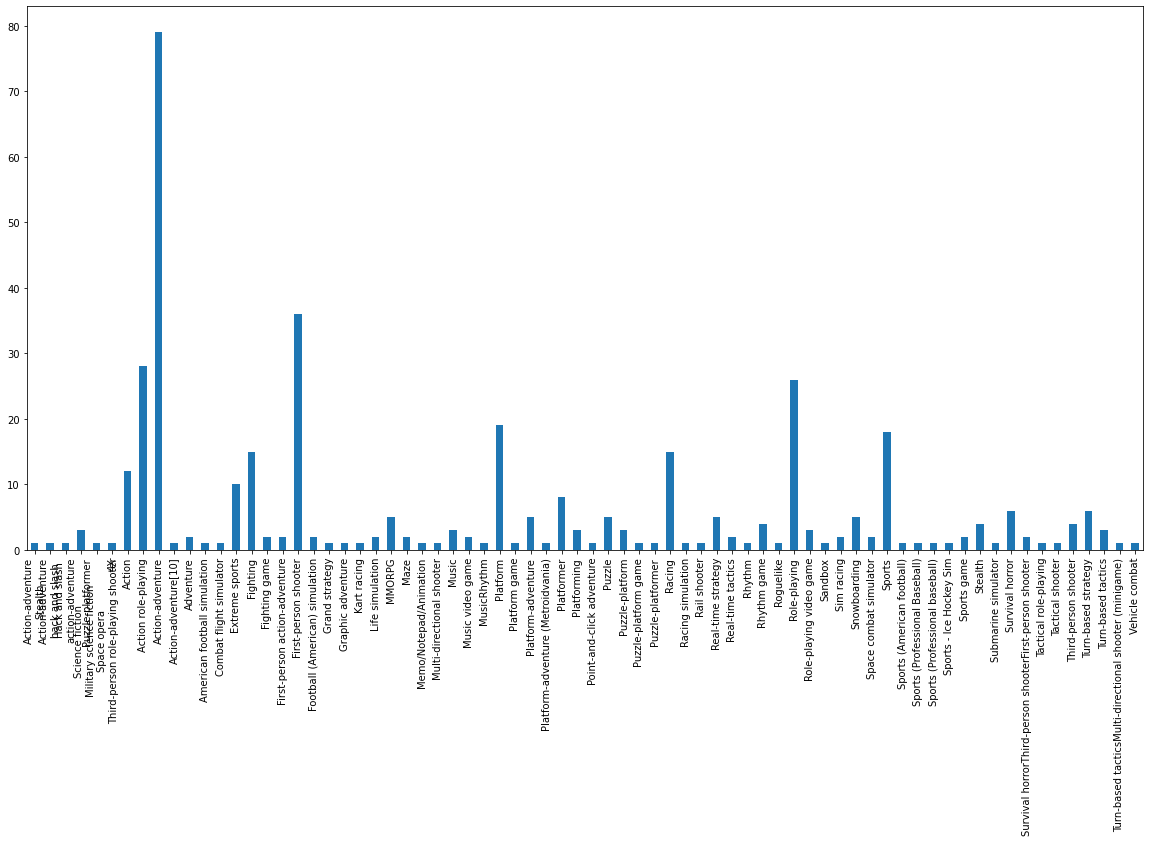

In [22]:
y = df_without_null['genres']
y.value_counts().sort_index().plot.bar(figsize=(20,10), x='Target Value', y='Number of Occurrences')

##### __Conclusion__ : Action-adventure, FPS and role playing games fare the best

#### Number of games by year in the top 500

<AxesSubplot:>

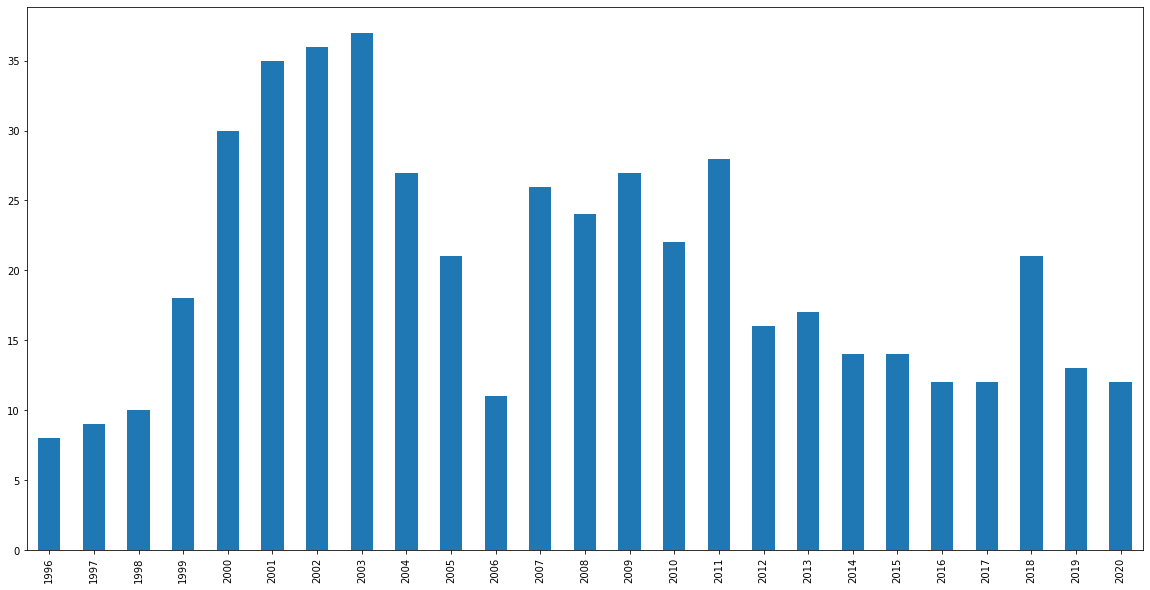

In [23]:
y = df["release_date"].dt.year
y.value_counts().sort_index().plot.bar(figsize=(20,10), x='Target Value', y='Number of Occurrences')

##### __Conclusion__ : A lot of games where released in 2001-2003 probably following the release of the PS2, weirdly very little games were released in 2006 though the xbox 360 was released the year before 

#### Comparing professional and user rankings

In [24]:
df_ranking = pd.DataFrame(columns = ['metacritic_rating', 'user_rating'])
df_ranking['metacritic_rating'] = df_without_null['metacritic_rating'].astype(np.float16)
df_ranking['user_rating'] = df_without_null['user_rating'].astype(np.float16)


In [25]:
df_ranking.corr()

,metacritic_rating,user_rating
metacritic_rating,1.000000,0.164921
user_rating,0.164921,1.000000


In [26]:
df_int = pd.DataFrame(columns = ['metacritic_rating', 'user_rating'])

##### __Conclusion__ : users and professionals seem to rarely agree on game quality

#### Check if user rating and and platform are related

In [30]:
df_without_null['platform_as_cat'] = pd.Categorical(df_without_null.platform)
df_without_null.dtypes

name                         object
release_date         datetime64[ns]
platform                     object
user_rating                  object
metacritic_rating            object
genres                       object
developers                   object
platform_as_cat            category
dtype: object

In [34]:
df_ranking_ag_plat = pd.DataFrame(columns = ['platform_cat_code', 'user_rating'])


df_ranking_ag_plat['platform_cat_code'] = df_without_null.platform_as_cat.cat.codes.astype(np.float64)
df_ranking_ag_plat['user_rating'] = df_without_null['user_rating'].astype(np.float64)


In [35]:
df_ranking_ag_plat

,platform_cat_code,user_rating
0,5.0,9.1
2,10.0,7.6
3,2.0,8.5
4,17.0,7.9
5,14.0,9.0
...,...,...
492,0.0,8.3
493,11.0,9.0
494,17.0,8.8
495,9.0,8.3


In [42]:
df_ranking_ag_plat.corr()

,platform_cat_code,user_rating
platform_cat_code,1.000000,-0.182307
user_rating,-0.182307,1.000000


##### __Conclusion__ : user_rating and platform are unrelated